In [16]:
import re
import sys
import numpy as np
import gzip
import json
import itertools
from collections import defaultdict

import nltk
import networkx as nx
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')

WORKING_DIR = 'drive/MyDrive/dtsa5800_tweets_network_analysis'
DATA_DIR = f'{WORKING_DIR}/data'
DATA_FILE = f'{DATA_DIR}/nikelululemonadidas_tweets.jsonl.gz'

## Semantic Network Graph

In [2]:
tweets = {}
with gzip.open(DATA_FILE, 'r') as f:
    for i, line in enumerate(f):
        tweet = json.loads(line)
        tweet_id =tweet.get('id', i)
        text = tweet.get('full_text') or tweet.get('text' or '')
        tweets[str(tweet_id)] = text

len(tweets)

175077

In [3]:
def get_wordnet_pos(tag):
    WN = nltk.corpus.wordnet
    if tag.startswith('J'):
        return WN.ADJ
    elif tag.startswith('V'):
        return WN.VERB
    elif tag.startswith('N'):
        return WN.NOUN
    elif tag.startswith('R'):
        return WN.ADV
    else:
        return None

def process_text(text, further_stopwords=None, min_length=3, remove_mentions=False, remove_hashtags=False):

    STOPWORDS = set(nltk.corpus.stopwords.words('english')).union(further_stopwords)
    LEMMATIZER = nltk.stem.WordNetLemmatizer()
    TTOKENIZER = nltk.tokenize.TweetTokenizer()

    tokens = TTOKENIZER.tokenize(text.lower())
    tokens = [t for t in tokens if not t.startswith(("http://", "https://"))]
    if remove_mentions:
        tokens = [t for t in tokens if '@' not in t]
    if remove_hashtags:
        tokens = [t for t in tokens if '#' not in t]

    processed_tokens = []
    for token in tokens:
        sub_tokens = re.findall(r'[a-zA-Z]+', token)
        tagged = nltk.pos_tag(sub_tokens)
        for token, tag in tagged:
            wntag = get_wordnet_pos(tag)
            if wntag is None:
                lem_token = LEMMATIZER.lemmatize(token)
            else:
                lem_token = LEMMATIZER.lemmatize(token, pos=wntag)
            if lem_token not in STOPWORDS and len(lem_token) >= min_length:
                processed_tokens.append(lem_token)

    return processed_tokens


In [6]:
def build_graph(processed_tokens_dict, selected_words):
    graph = nx.Graph()
    for tweet_id, tokens in processed_tokens_dict.items():
        nodes = [t for t in tokens if t in selected_words]
        cooccurrences = itertools.combinations(nodes, 2)
        graph.add_edges_from(cooccurrences)

    nodes = graph.number_of_nodes()
    edges = graph.number_of_edges()
    print(f"Graph has {nodes} nodes and {edges} edges.")
    return graph

def draw_network_graph(graph, figsize=(20, 15), node_size=800):
    pos = nx.spring_layout(graph, k=0.15, iterations=20)
    plt.figure(figsize=figsize)
    nx.draw_networkx(graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=node_size, width=1)
    plt.show()

 ### Remove url, keep only letters, lemmatize, remove stopwords

In [ ]:
N = 30
processed_tweets = {}
word_counts = defaultdict(int)
further_sws = ['http', 'via', 'get', 'one', 'three', 'let', 'thee', 'dear']

for tweet_id, text in tweets.items():
    tokens = process_text(text, further_sws)
    processed_tweets[tweet_id] = tokens
    for word in tokens:
        word_counts[word] += 1

sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
sorted_words = [word for word, count in sorted_counts]
top_words = sorted_words[:N]
print(top_words)

['nike', 'adidas', 'xbox', 'sneakerscouts', 'eneskanter', 'day', 'available', 'air', 'china', 'kingjames', 'try', 'win', 'together', 'nikestore', 'jumpman', 'austinekeler', 'book', 'knight', 'phil', 'fly', 'owner', 'follow', 'ticket', 'adidasfballus', 'finishline', 'plane', 'xboxsweepstakes', 'chance', 'include', 'like']


In [ ]:
graph1 = build_graph(processed_tweets, top_words)

Graph has 30 nodes and 359 edges.


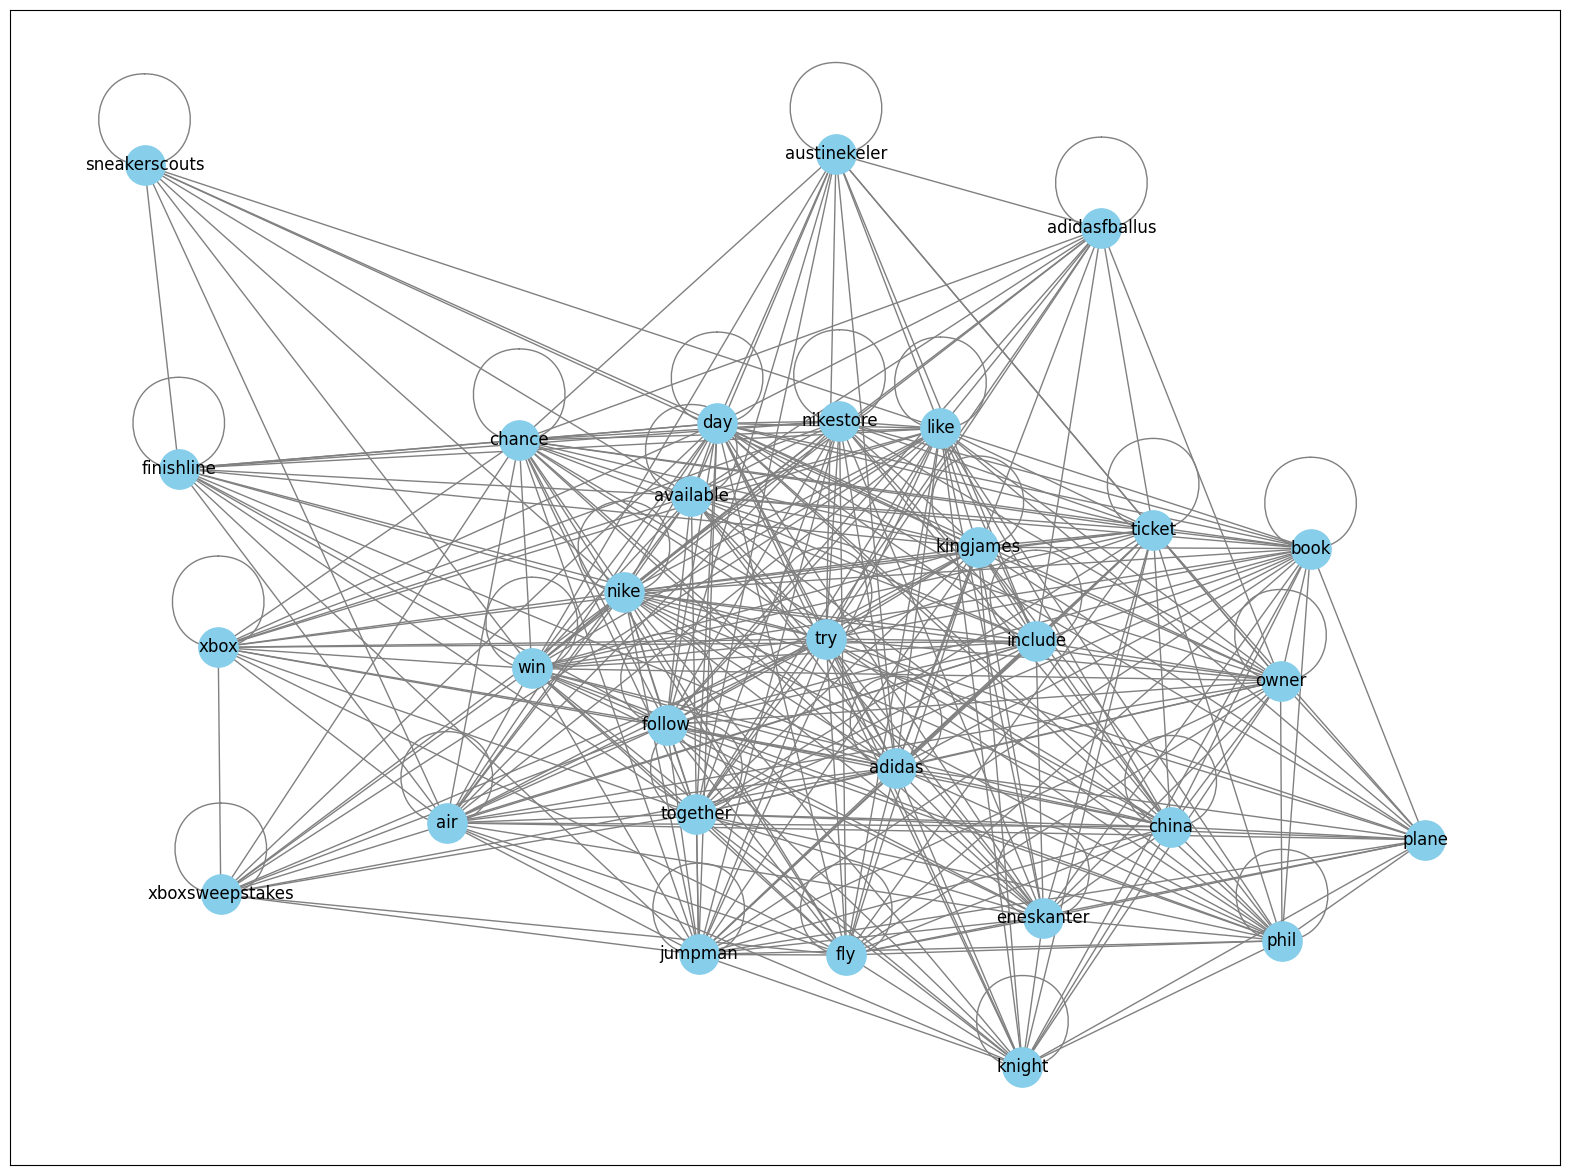

In [ ]:
draw_network_graph(graph1)

### Remove mentions, and filter by threshold

In [9]:
N = 100
processed_tweets = {}
word_counts = defaultdict(int)
further_sws = ['que', 'hmn', 'fin', 'ahhh', 'gooooo', 'oops']

for tweet_id, text in tweets.items():
    tokens = process_text(text, further_sws,remove_mentions=True)
    processed_tweets[tweet_id] = tokens
    for word in tokens:
        word_counts[word] += 1

sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)

frequency_threshold_upper = 88
frequency_threshold_lower = 1

upper_limit = np.percentile(list(word_counts.values()), frequency_threshold_upper)
lower_limit = np.percentile(list(word_counts.values()), frequency_threshold_lower)

filtered_sorted_worted = [word for word, count in sorted_counts if lower_limit < count < upper_limit]
top_words = filtered_sorted_worted[:N]
print(top_words)

['happier', 'abroad', 'harden', 'bend', 'simpson', 'latino', 'lucrative', 'bump', 'customizable', 'chelsea', 'lisa', 'upgraded', 'blend', 'useful', 'finance', 'cast', 'flaw', 'hawaii', 'sing', 'shoulda', 'bathroom', 'alt', 'perception', 'tradition', 'sentence', 'affiliate', 'wavy', 'expectation', 'indigenous', 'shark', 'airport', 'retain', 'backyard', 'thick', 'ethnic', 'implement', 'socksmith', 'document', 'filter', 'closely', 'rubber', 'hlvb', 'sneaklife', 'consistently', 'matchup', 'ali', 'capitalize', 'madison', 'profitable', 'assure', 'mislead', 'aspect', 'blk', 'fiber', 'district', 'belongs', 'drawing', 'fab', 'superb', 'belief', 'bronze', 'emotional', 'sway', 'insurance', 'shell', 'centralize', 'shopper', 'olympian', 'gamer', 'inflation', 'adolf', 'hitler', 'fort', 'passionate', 'wasnt', 'futsalbenfica', 'fgilautomoveis', 'servilusa', 'liskasas', 'subtle', 'interviewed', 'brook', 'scientist', 'fairness', 'colorado', 'scratch', 'getfit', 'menswear', 'ideal', 'duty', 'icy', 'singl

In [10]:
graph2 = build_graph(processed_tweets, top_words)

Graph has 48 nodes and 47 edges.


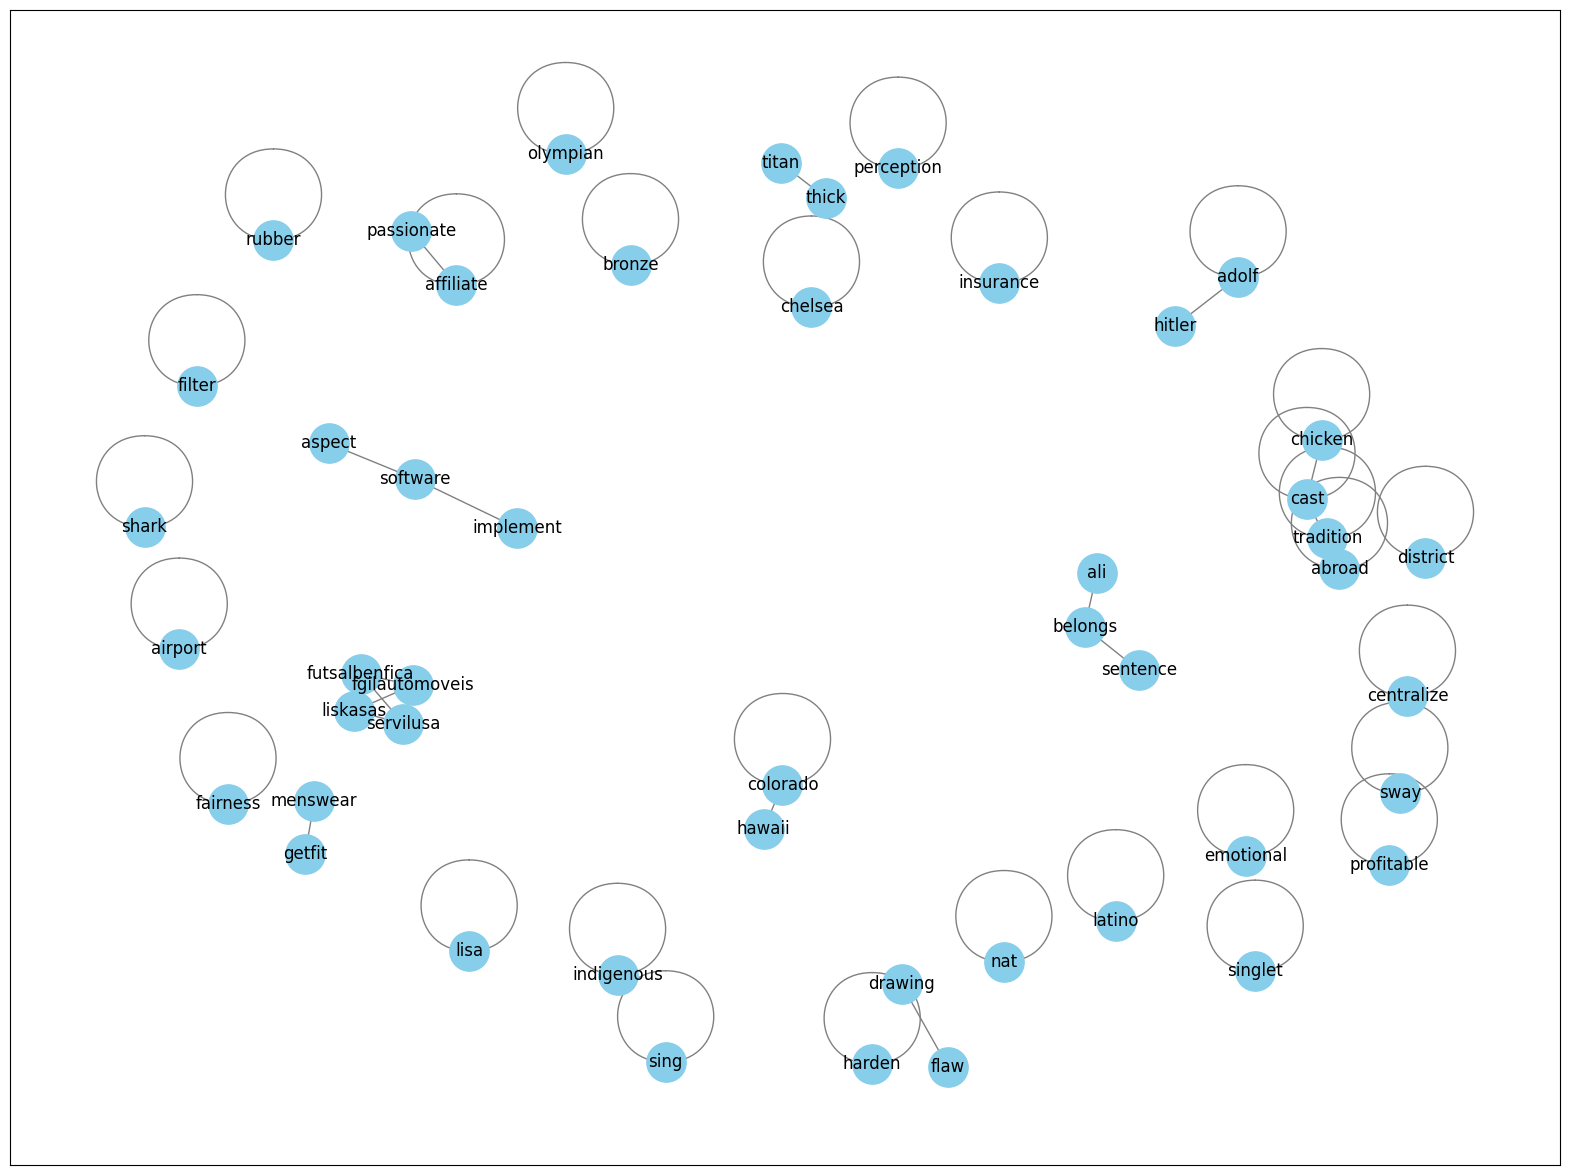

In [15]:
draw_network_graph(graph2)

### Remove mentions and hashtags, and filter by threshold

In [ ]:
N = 100
processed_tweets = {}
word_counts = defaultdict(int)
further_sws = ['supa', 'esp', 'ave', 'asf', 'ass']

for tweet_id, text in tweets.items():
    tokens = process_text(text, further_sws,remove_mentions=True, remove_hashtags=True)
    processed_tweets[tweet_id] = tokens
    for word in tokens:
        word_counts[word] += 1

sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)

frequency_threshold_upper = 88
frequency_threshold_lower = 1

upper_limit = np.percentile(list(word_counts.values()), frequency_threshold_upper)
lower_limit = np.percentile(list(word_counts.values()), frequency_threshold_lower)

filtered_sorted_worted = [word for word, count in sorted_counts if lower_limit < count < upper_limit]
top_words = filtered_sorted_worted[:N]
print(top_words)

['bug', 'understood', 'coral', 'hawk', 'pullover', 'cushion', 'pad', 'therapist', 'adapt', 'existence', 'prolly', 'flop', 'template', 'ensure', 'category', 'manifest', 'awhile', 'iron', 'vest', 'reaction', 'unfair', 'rarely', 'obesity', 'wider', 'financially', 'nephew', 'garden', 'therapy', 'internal', 'fabulous', 'bound', 'tinker', 'incorporate', 'disgrace', 'asia', 'flow', 'motivation', 'understands', 'nature', 'democracy', 'fade', 'nashville', 'timeline', 'spoken', 'drawn', 'premier', 'employer', 'tokyo', 'uncomfortable', 'transit', 'scamming', 'entertainment', 'bob', 'consequence', 'flower', 'desert', 'village', 'lower', 'ekeler', 'hurry', 'rent', 'utter', 'budget', 'rap', 'cricket', 'amm', 'fut', 'vampire', 'kiko', 'regional', 'pewter', 'tuff', 'dip', 'somethin', 'dis', 'resist', 'shill', 'illustration', 'condemn', 'emission', 'pin', 'raid', 'photographer', 'globe', 'curse', 'rely', 'sack', 'systemic', 'lecture', 'intend', 'converse', 'desperate', 'flame', 'wack', 'badly', 'durant

In [ ]:
graph3 = build_graph(processed_tweets, top_words)

Graph has 67 nodes and 74 edges.


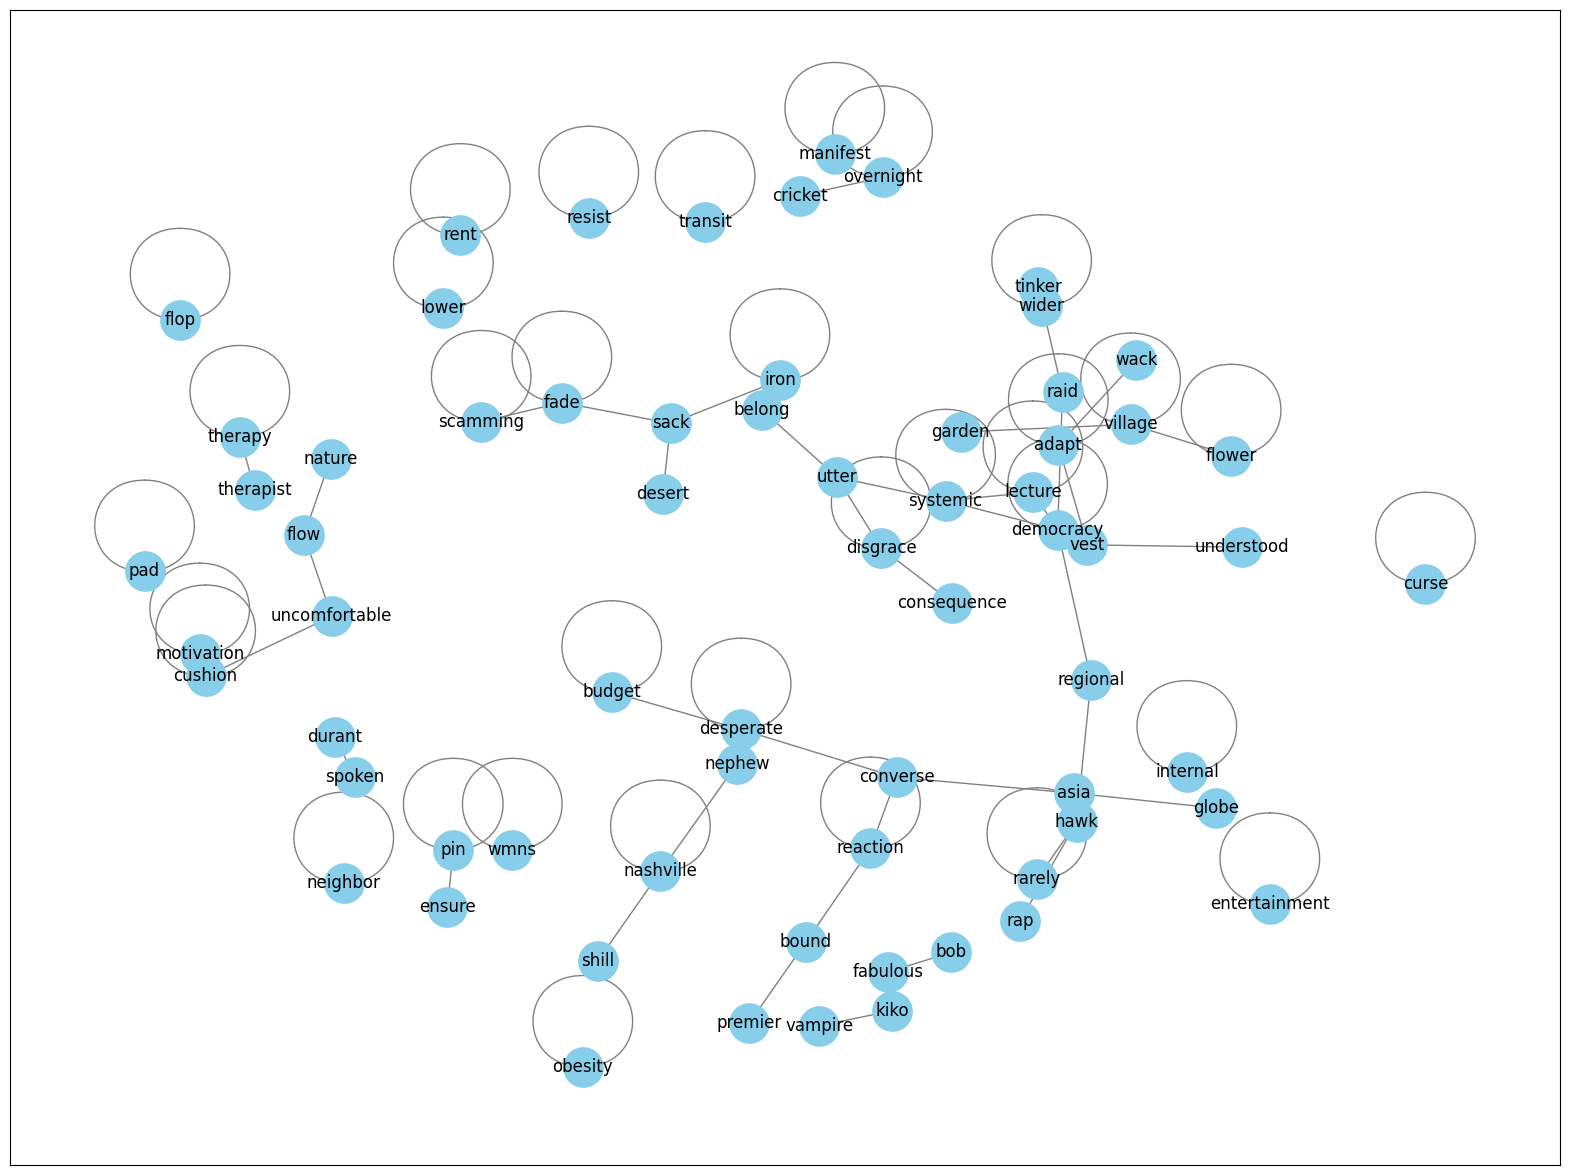

In [ ]:
draw_network_graph(graph3)